In [1]:
import os.path

import fitz
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

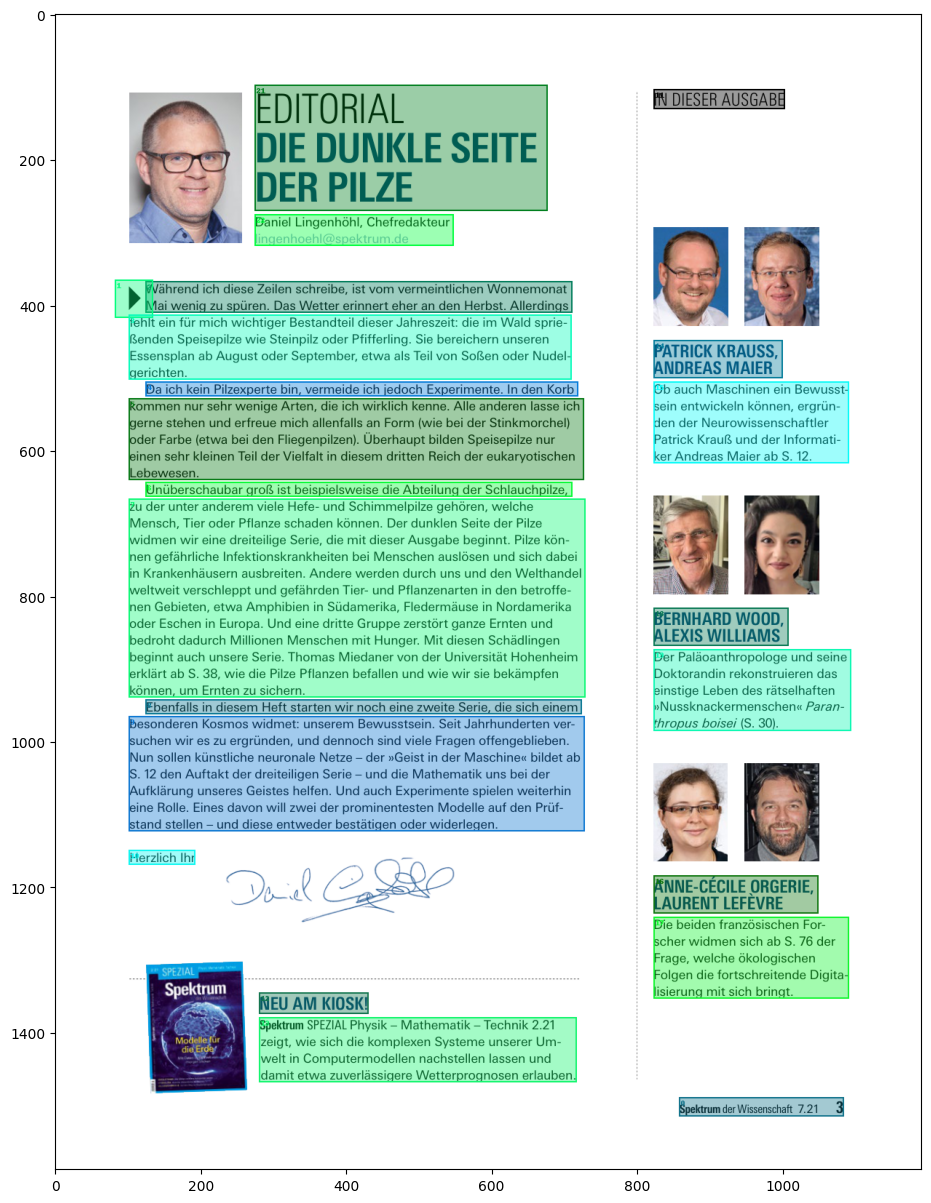

In [18]:

def plot_page_at(page_num, pdf_path, include_text=True, include_image=True, include_table=False):
    data_type_map = {0:"text", 1:"image"}
    data_types = []
    if include_text:
        data_types.append(0) # 0代表文字块
    if include_image:
        data_types.append(1) # 1代表图片

    annotation = []
    zoom_x = zoom_y = 2
    raw_img_path = f"{os.path.basename(pdf_path)}-{page_num}.raw.png"
    raw_img_output_path = f"{os.path.basename(pdf_path)}-{page_num}.ouput.png"
    with fitz.open(pdf_path) as doc:
        page = doc[page_num]
        this_anns = page.get_text("blocks", sort=True)
        for ann in this_anns:
            x0, y0, x1, y1 = ann[:4]
            text = ann[4]
            block_num = ann[5]
            data_type = ann[6]

            if data_type not in data_types:
                continue
            
            this_ann = {
                "bbox": [x0 * zoom_x, y0 * zoom_y, x1 * zoom_x, y1 * zoom_y],
                "text": text.strip(),
                "block_num": block_num,
                "data_type": data_type
            }
            annotation.append(this_ann)

        mat = fitz.Matrix(zoom_x, zoom_y)
        pix = page.get_pixmap(matrix=mat)
        pix.save(raw_img_path)

    img = read_image(raw_img_path)
    boxes = [_["bbox"] for _ in annotation]
    labels = [str(_["block_num"]) for _ in annotation]
    boxes = torch.tensor(boxes, dtype=torch.int)

    img_vis = draw_bounding_boxes(img, boxes, width=2, fill=True, labels=labels)
    img_vis = torchvision.transforms.ToPILImage()(img_vis)

    # display output
    img_vis.save(raw_img_output_path)

    plt.figure(figsize=(20,15))
    # 显示原始图片和打标的图片
    # img = mpimg.imread(img_path)
    # plt.imshow(img)

    img_anno = mpimg.imread(raw_img_output_path)
    plt.imshow(img_anno)
        
        
pdf_path = r"1page.pdf"
plot_page_at(0, pdf_path, True, False)
            



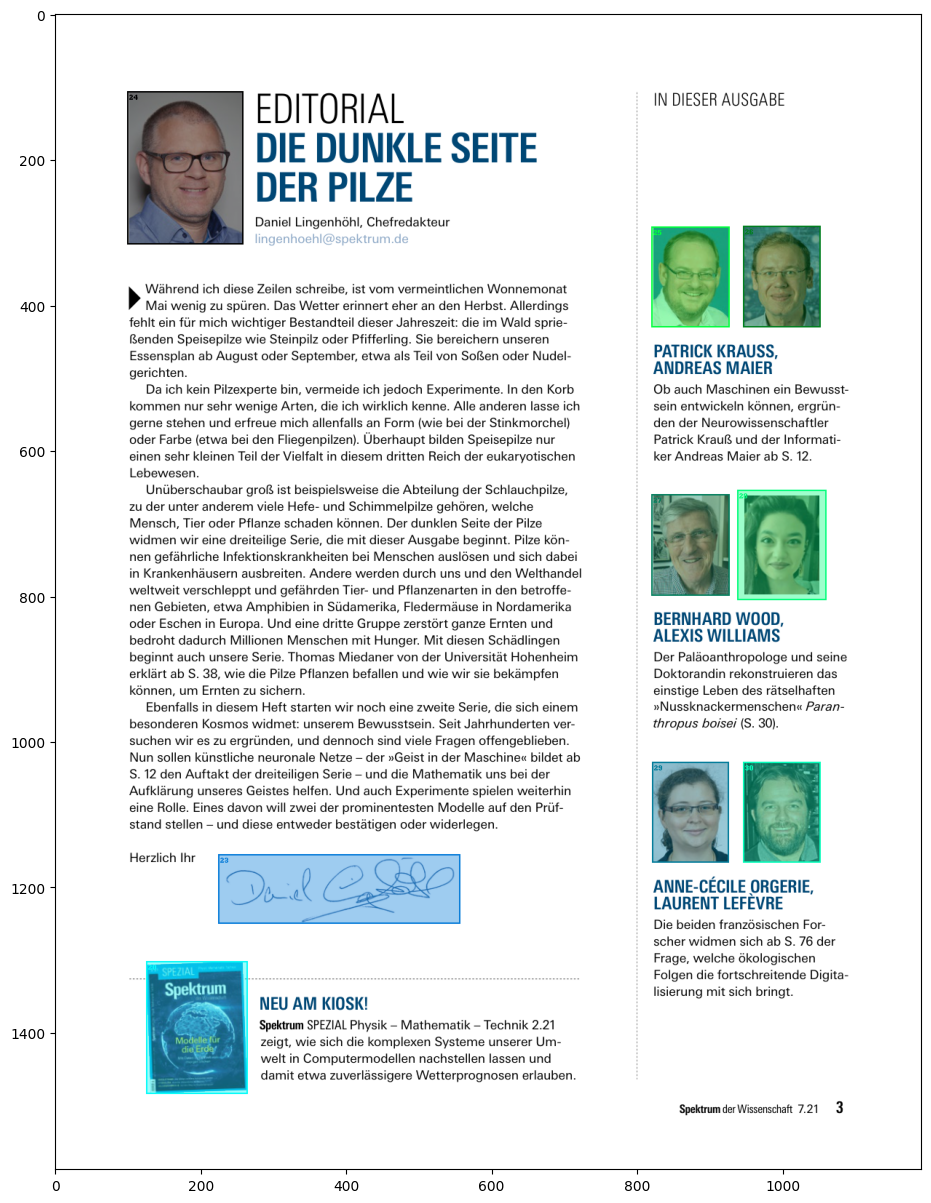

In [19]:
plot_page_at(0, pdf_path, False, True)

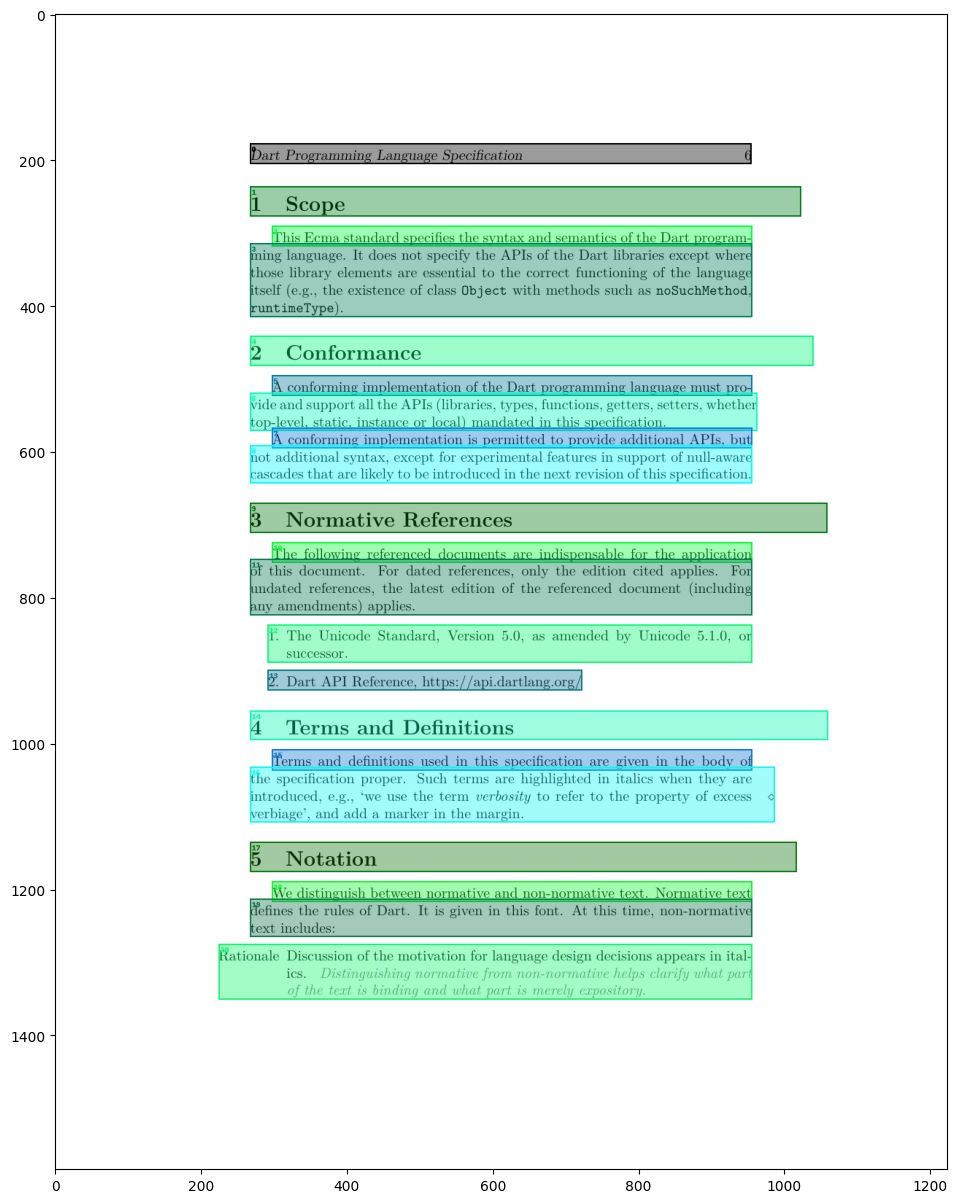

In [21]:
plot_page_at(0, "Dart.pdf", True, True)

In [25]:
"""
This is an advanced PyMuPDF utility for detecting multi-column pages.
It can be used in a shell script, or its main function can be imported and
invoked as descript below.

Features
---------
- Identify text belonging to (a variable number of) columns on the page.
- Text with different background color is handled separately, allowing for
  easier treatment of side remarks, comment boxes, etc.
- Uses text block detection capability to identify text blocks and
  uses the block bboxes as primary structuring principle.
- Supports ignoring footers via a footer margin parameter.
- Returns re-created text boundary boxes (integer coordinates), sorted ascending
  by the top, then by the left coordinates.

Restrictions
-------------
- Only supporting horizontal, left-to-right text
- Returns a list of text boundary boxes - not the text itself. The caller is
  expected to extract text from within the returned boxes.
- Text written above images is ignored altogether (option).
- This utility works as expected in most cases. The following situation cannot
  be handled correctly:
    * overlapping (non-disjoint) text blocks
    * image captions are not recognized and are handled like normal text

Usage
------
- As a CLI shell command use

  python multi_column.py input.pdf footer_margin

  Where footer margin is the height of the bottom stripe to ignore on each page.
  This code is intended to be modified according to your need.

- Use in a Python script as follows:

  ----------------------------------------------------------------------------------
  from multi_column import column_boxes

  # for each page execute
  bboxes = column_boxes(page, footer_margin=50, no_image_text=True)

  # bboxes is a list of fitz.IRect objects, that are sort ascending by their y0,
  # then x0 coordinates. Their text content can be extracted by all PyMuPDF
  # get_text() variants, like for instance the following:
  for rect in bboxes:
      print(page.get_text(clip=rect, sort=True))
  ----------------------------------------------------------------------------------
"""
import os
import sys
import fitz


def column_boxes(page, footer_margin=50, header_margin=50, no_image_text=True):
    """Determine bboxes which wrap a column."""
    paths = page.get_drawings()
    bboxes = []

    # path rectangles
    path_rects = []

    # image bboxes
    img_bboxes = []

    # bboxes of non-horizontal text
    # avoid when expanding horizontal text boxes
    vert_bboxes = []

    # compute relevant page area
    clip = +page.rect
    clip.y1 -= footer_margin  # Remove footer area
    clip.y0 += header_margin  # Remove header area

    def can_extend(temp, bb, bboxlist):
        """Determines whether rectangle 'temp' can be extended by 'bb'
        without intersecting any of the rectangles contained in 'bboxlist'.

        Items of bboxlist may be None if they have been removed.

        Returns:
            True if 'temp' has no intersections with items of 'bboxlist'.
        """
        for b in bboxlist:
            if not intersects_bboxes(temp, vert_bboxes) and (
                b == None or b == bb or (temp & b).is_empty
            ):
                continue
            return False

        return True

    def in_bbox(bb, bboxes):
        """Return 1-based number if a bbox contains bb, else return 0."""
        for i, bbox in enumerate(bboxes):
            if bb in bbox:
                return i + 1
        return 0

    def intersects_bboxes(bb, bboxes):
        """Return True if a bbox intersects bb, else return False."""
        for bbox in bboxes:
            if not (bb & bbox).is_empty:
                return True
        return False

    def extend_right(bboxes, width, path_bboxes, vert_bboxes, img_bboxes):
        """Extend a bbox to the right page border.

        Whenever there is no text to the right of a bbox, enlarge it up
        to the right page border.

        Args:
            bboxes: (list[IRect]) bboxes to check
            width: (int) page width
            path_bboxes: (list[IRect]) bboxes with a background color
            vert_bboxes: (list[IRect]) bboxes with vertical text
            img_bboxes: (list[IRect]) bboxes of images
        Returns:
            Potentially modified bboxes.
        """
        for i, bb in enumerate(bboxes):
            # do not extend text with background color
            if in_bbox(bb, path_bboxes):
                continue

            # do not extend text in images
            if in_bbox(bb, img_bboxes):
                continue

            # temp extends bb to the right page border
            temp = +bb
            temp.x1 = width

            # do not cut through colored background or images
            if intersects_bboxes(temp, path_bboxes + vert_bboxes + img_bboxes):
                continue

            # also, do not intersect other text bboxes
            check = can_extend(temp, bb, bboxes)
            if check:
                bboxes[i] = temp  # replace with enlarged bbox

        return [b for b in bboxes if b != None]

    def clean_nblocks(nblocks):
        """Do some elementary cleaning."""

        # 1. remove any duplicate blocks.
        blen = len(nblocks)
        if blen < 2:
            return nblocks
        start = blen - 1
        for i in range(start, -1, -1):
            bb1 = nblocks[i]
            bb0 = nblocks[i - 1]
            if bb0 == bb1:    # 这个为什么会出现呢？
                del nblocks[i]

        # 2. repair sequence in special cases:
        # consecutive bboxes with almost same bottom value are sorted ascending
        # by x-coordinate.
        y1 = nblocks[0].y1  # first bottom coordinate
        i0 = 0  # its index
        i1 = -1  # index of last bbox with same bottom

        # Iterate over bboxes, identifying segments with approx. same bottom value.
        # Replace every segment by its sorted version.
        for i in range(1, len(nblocks)):
            b1 = nblocks[i]
            if abs(b1.y1 - y1) > 10:  # different bottom
                if i1 > i0:  # segment length > 1? Sort it!
                    nblocks[i0 : i1 + 1] = sorted(
                        nblocks[i0 : i1 + 1], key=lambda b: b.x0
                    )
                y1 = b1.y1  # store new bottom value
                i0 = i  # store its start index
            i1 = i  # store current index
        if i1 > i0:  # segment waiting to be sorted
            nblocks[i0 : i1 + 1] = sorted(nblocks[i0 : i1 + 1], key=lambda b: b.x0)
        return nblocks

    # extract vector graphics
    for p in paths:
        path_rects.append(p["rect"].irect)
    path_bboxes = path_rects

    # sort path bboxes by ascending top, then left coordinates
    path_bboxes.sort(key=lambda b: (b.y0, b.x0))

    # bboxes of images on page, no need to sort them
    for item in page.get_images():
        img_bboxes.extend(page.get_image_rects(item[0]))

    # blocks of text on page
    blocks = page.get_text(
        "dict",
        flags=fitz.TEXTFLAGS_TEXT,
        clip=clip,
    )["blocks"]

    # Make block rectangles, ignoring non-horizontal text
    for b in blocks:
        bbox = fitz.IRect(b["bbox"])  # bbox of the block

        # ignore text written upon images
        if no_image_text and in_bbox(bbox, img_bboxes):
            continue

        # confirm first line to be horizontal
        line0 = b["lines"][0]  # get first line
        if line0["dir"] != (1, 0):  # only accept horizontal text
            vert_bboxes.append(bbox)
            continue

        srect = fitz.EMPTY_IRECT()
        for line in b["lines"]:
            lbbox = fitz.IRect(line["bbox"])
            text = "".join([s["text"].strip() for s in line["spans"]])
            if len(text) > 1:
                srect |= lbbox
        bbox = +srect

        if not bbox.is_empty:
            bboxes.append(bbox)

    # Sort text bboxes by ascending background, top, then left coordinates
    bboxes.sort(key=lambda k: (in_bbox(k, path_bboxes), k.y0, k.x0))

    # Extend bboxes to the right where possible
    bboxes = extend_right(
        bboxes, int(page.rect.width), path_bboxes, vert_bboxes, img_bboxes
    )

    # immediately return of no text found
    if bboxes == []:
        return []

    # --------------------------------------------------------------------
    # Join bboxes to establish some column structure
    # --------------------------------------------------------------------
    # the final block bboxes on page
    nblocks = [bboxes[0]]  # pre-fill with first bbox
    bboxes = bboxes[1:]  # remaining old bboxes

    for i, bb in enumerate(bboxes):  # iterate old bboxes
        check = False  # indicates unwanted joins

        # check if bb can extend one of the new blocks
        for j in range(len(nblocks)):
            nbb = nblocks[j]  # a new block

            # never join across columns
            if bb == None or nbb.x1 < bb.x0 or bb.x1 < nbb.x0:
                continue

            # never join across different background colors
            if in_bbox(nbb, path_bboxes) != in_bbox(bb, path_bboxes):
                continue

            temp = bb | nbb  # temporary extension of new block
            check = can_extend(temp, nbb, nblocks)
            if check == True:
                break

        if not check:  # bb cannot be used to extend any of the new bboxes
            nblocks.append(bb)  # so add it to the list
            j = len(nblocks) - 1  # index of it
            temp = nblocks[j]  # new bbox added

        # check if some remaining bbox is contained in temp
        check = can_extend(temp, bb, bboxes)
        if check == False:
            nblocks.append(bb)
        else:
            nblocks[j] = temp
        bboxes[i] = None

    # do some elementary cleaning
    nblocks = clean_nblocks(nblocks)

    # return identified text bboxes
    return nblocks


if __name__ == "__main__":
    """Only for debugging purposes, currently.

    Draw red borders around the returned text bboxes and insert
    the bbox number.
    Then save the file under the name "input-blocks.pdf".
    """

    # get the file name
    filename = "ctw_findpeaks.pdf"
    footer_margin = 50

    # check if footer margin is given
    # if len(sys.argv) > 2:
    #     footer_margin = int(sys.argv[2])
    # else:  # use default vaue
    #     footer_margin = 50

    # check if header margin is given
    if len(sys.argv) > 3:
        header_margin = int(sys.argv[3])
    else:  # use default vaue
        header_margin = 50

    # open document
    doc = fitz.open(filename)

    # iterate over the pages
    for page in doc:
        # remove any geometry issues
        page.wrap_contents()

        # get the text bboxes
        bboxes = column_boxes(page, footer_margin=footer_margin, header_margin=header_margin)

        # prepare a canvas to draw rectangles and text
        shape = page.new_shape()

        # iterate over the bboxes
        for i, rect in enumerate(bboxes):
            shape.draw_rect(rect)  # draw a border

            # write sequence number
            shape.insert_text(rect.tl + (5, 15), str(i), color=fitz.pdfcolor["red"])

        # finish drawing / text with color red
        shape.finish(color=fitz.pdfcolor["red"])
        shape.commit()  # store to the page

    # save document with text bboxes
    doc.ez_save(filename.replace(".pdf", "-blocks.pdf"))



In [27]:
mypage = doc[0]
bboxes = column_boxes(mypage, footer_margin=footer_margin, header_margin=header_margin)
bboxes[0]

IRect(53, 37, 555, 203)

In [29]:
type(bboxes[0].tl)

fitz.fitz.Point